In [1]:
%store -r sheyenne_grasslands_gdf caddo_grasslands_gdf data_dir

In [2]:
# Import necessary packages
import os
from glob import glob

import earthaccess # Access NASA data from the cloud
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
import xrspatial

c:\Users\riede\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Load in elevation data for each grassland from the SRTM as raster data.

### Download Sheyenne elevation data

In [3]:
# Define data directory for the Sheyenne elevation data
sheyenne_elevation_dir = os.path.join(data_dir, 'sheyenne-elevation-srtm')

os.makedirs(sheyenne_elevation_dir, exist_ok=True)

sheyenne_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm'

In [4]:
# Log in to earthaccess
earthaccess.login()

# Search earthaccess datasets for SRTM
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
GFSAD30EUCEARUMECE Global Food Security-support Analysis Data (GFSAD) Cropland Extent 2015 Europe, Central Asia, Russia, Middle East product 30 m V001
GFSAD30SA

In [5]:
# Sheyenne data search
sheyenne_srtm_pattern = os.path.join(sheyenne_elevation_dir, '*.hgt.zip')

# Define Sheyenne elevation bounds
sheyenne_elev_bounds = tuple(sheyenne_grasslands_gdf.total_bounds)

# Add buffer to Sheyenne elevation bounds
buffer = .025
sheyenne_xmin, sheyenne_ymin, sheyenne_xmax, sheyenne_ymax = sheyenne_elev_bounds
sheyenne_elev_bounds_buffer = (sheyenne_xmin-buffer,
                               sheyenne_ymin-buffer,
                               sheyenne_xmax+buffer,
                               sheyenne_ymax+buffer)

if glob(sheyenne_srtm_pattern):
    # Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
    sheyenne_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=sheyenne_elev_bounds_buffer
    )
    # Download SRTM files
    sheyenne_srtm_results = earthaccess.download(
        sheyenne_srtm_search,
        sheyenne_elevation_dir)

# Check sheyenne_srtm_results download
# srtm dataset files are geotiffs but they instead have a .hgt tag (height)
# results are also .zip files
sheyenne_srtm_results

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm\\N46W097.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm\\N46W098.SRTMGL1.hgt.zip']

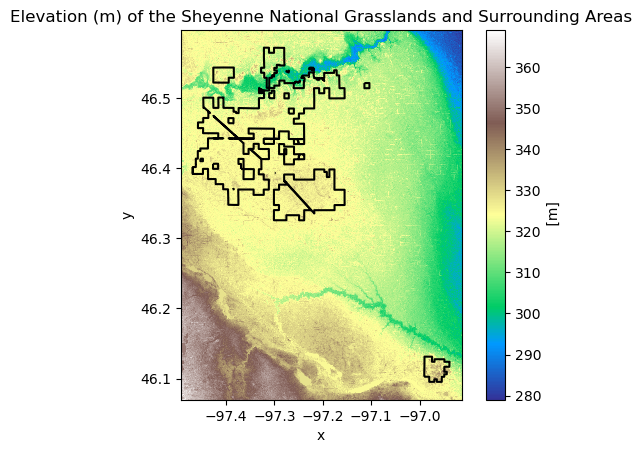

In [6]:
# Open Sheyenne SRTM files
sheyenne_srtm_da_list = []
for srtm_path in glob(sheyenne_srtm_pattern):
    # Open files and put them in a DataArray
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop DataArrays
    srtm_cropped_da = tile_da.rio.clip_box(*sheyenne_elev_bounds_buffer)
    sheyenne_srtm_da_list.append(srtm_cropped_da)
    
# Merge tiles
sheyenne_srtm_da = merge_arrays(sheyenne_srtm_da_list)

# Check SRTM data w/ Sheyenne plotted on top
sheyenne_srtm_da.plot(cmap='terrain')

sheyenne_grasslands_gdf.boundary.plot(ax = plt.gca(), color='black')
plt.title('Elevation (m) of the Sheyenne National Grasslands and Surrounding Areas')
plt.show()

### Download Caddo elevation data

In [7]:
# Define data directory for the Caddo elevation data
caddo_elevation_dir = os.path.join(data_dir, 'caddo-elevation-srtm')

os.makedirs(caddo_elevation_dir, exist_ok=True)

caddo_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm'

In [8]:
# Caddo data search
caddo_srtm_pattern = os.path.join(caddo_elevation_dir, '*.hgt.zip')

# Define Caddo elevation bounds
caddo_elev_bounds = tuple(caddo_grasslands_gdf.total_bounds)

# Add .025 buffer to bounds
c_xmin, c_ymin, c_xmax, c_ymax = caddo_elev_bounds
caddo_elev_bounds_buffer = (c_xmin-buffer,
                            c_ymin-buffer,
                            c_xmax+buffer,
                            c_ymax+buffer)

if glob(caddo_srtm_pattern):
    caddo_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=caddo_elev_bounds_buffer
    )
    # Download SRTM files
    caddo_srtm_results = earthaccess.download(caddo_srtm_search,
                                              caddo_elevation_dir)

# Check caddo_srtm_results download
caddo_srtm_results

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm\\N33W097.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm\\N33W096.SRTMGL1.hgt.zip']

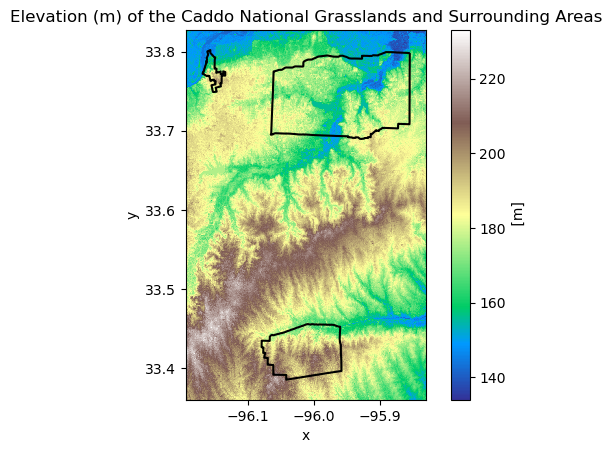

In [9]:
# Open Caddo SRTM files
caddo_srtm_da_list = []
for srtm_path in glob(caddo_srtm_pattern):
    # Open files and put them in a DataArray
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop DataArrays
    srtm_cropped_da = tile_da.rio.clip_box(*caddo_elev_bounds_buffer)
    caddo_srtm_da_list.append(srtm_cropped_da)
caddo_srtm_da_list
# Merge tiles
caddo_srtm_da = merge_arrays(caddo_srtm_da_list)

# Check SRTM data w/ Caddo plotted on top
caddo_srtm_da.plot(cmap='terrain')

caddo_grasslands_gdf.boundary.plot(ax = plt.gca(), color='black')
plt.title('Elevation (m) of the Caddo National Grasslands and Surrounding Areas')
plt.show()

## Calculate aspect for each grassland with the SRTM raster data.

### Calculate Sheyenne aspect
[Aspect info:](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA) Direction of the aspect can be determined by its value:
* From 0 to 22.5: North
* From 22.5 to 67.5: Northeast
* From 67.5 to 112.5: East
* From 112.5 to 157.5: Southeast
* From 157.5 to 202.5: South
* From 202.5 to 247.5: Southwest
* From 247.5 to 292.5: West
* From 292.5 to 337.5: Northwest
* From 337.5 to 360: North
* Values of -1 are flat areas

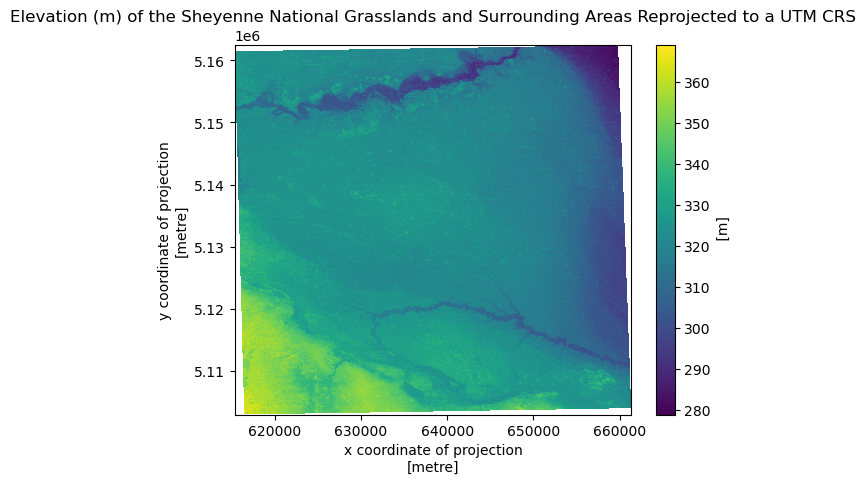

In [12]:
# Reproject srtm_da to a UTM projection
# Have to use rioxarray to handle coordinates of DataArray
utm14_epsg = 32614
sheyenne_srtm_proj_da = sheyenne_srtm_da.rio.reproject(utm14_epsg)
sheyenne_proj_gdf = sheyenne_grasslands_gdf.to_crs(utm14_epsg)

sheyenne_bounds_proj = tuple(sheyenne_proj_gdf.total_bounds)
sheyenne_srtm_proj_da.plot()

plt.title('Elevation (m) of the Sheyenne National Grasslands and Surrounding Areas '
          'Reprojected to a UTM CRS')
plt.show()

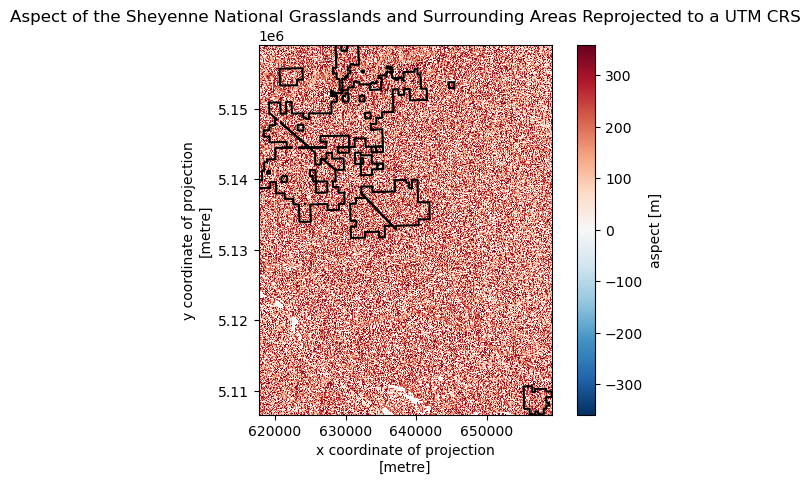

In [13]:
# Calculate & plot Sheyenne aspect
sheyenne_aspect_full_da = xrspatial.aspect(sheyenne_srtm_proj_da)
sheyenne_aspect_da = sheyenne_aspect_full_da.rio.clip_box(*sheyenne_bounds_proj)

sheyenne_aspect_da.plot()
sheyenne_proj_gdf.to_crs(utm14_epsg).boundary.plot(ax = plt.gca(), color='black')

# I was unable to change the colorbar label to show units of aspect instead of meters.

plt.title('Aspect of the Sheyenne National Grasslands and Surrounding Areas '
          'Reprojected to a UTM CRS')

plt.show()

### Calculate Caddo aspect

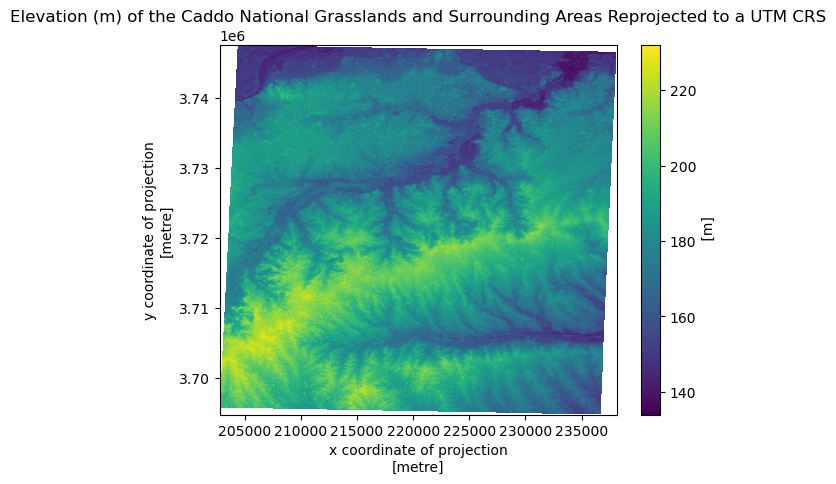

In [14]:
# Reproject caddo_srtm_da to a UTM projection
# Have to use rioxarray to handle coordinates of DataArray
utm15_epsg = 32615
caddo_srtm_proj_da = caddo_srtm_da.rio.reproject(utm15_epsg)
caddo_proj_gdf = caddo_grasslands_gdf.to_crs(utm15_epsg)

caddo_bounds_proj = tuple(caddo_proj_gdf.total_bounds)
caddo_srtm_proj_da.plot()

plt.title('Elevation (m) of the Caddo National Grasslands and Surrounding Areas '
          'Reprojected to a UTM CRS')
plt.show()

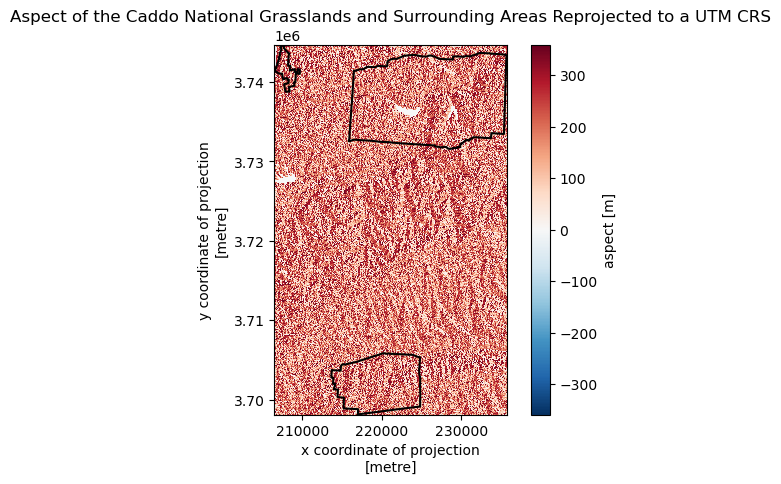

In [15]:
# Calculate & plot Caddo aspect
caddo_aspect_full_da = xrspatial.aspect(caddo_srtm_proj_da)
caddo_aspect_da = caddo_aspect_full_da.rio.clip_box(*caddo_bounds_proj)

caddo_aspect_da.plot()
caddo_proj_gdf.to_crs(utm15_epsg).boundary.plot(ax = plt.gca(), color='black')

# I was unable to change the colorbar label to show units of aspect instead of meters.

plt.title('Aspect of the Caddo National Grasslands and Surrounding Areas '
          'Reprojected to a UTM CRS')
plt.show()

In [16]:
%store sheyenne_aspect_da caddo_aspect_da

Stored 'sheyenne_aspect_da' (DataArray)
Stored 'caddo_aspect_da' (DataArray)
